# Particle charge classification with neural networks
#### By Jane Kim (janekim@ohio.edu, Clippinger 269)

Please install Keras by following [these instructions](https://www.tensorflow.org/install). You'll have to install TensorFlow, which contains Keras. 

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Activation, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

Wednesday's lecture will be an introduction to artificial neural networks. In this notebook, you will perform multi-class classification using dense feedforward neural networks and convolution neural networks.

## Exploring the data

You are given simulated detector data that visualizes the tracks of particles under the influence of a uniform external magnetic field. Each row of the data set is a different event, containing the track of only one particle. The first column of the data set corresponds to the charge (1, 0, or -1) and the remaining columns are the flattened images of the tracks. The pixel values in these images are proportional to the measured energy. The objective is to train a neural network to classify each event based on the charge of the particle.

First let's download the data. 

In [3]:
data = np.loadtxt("SimulatedDetectorData.csv", delimiter=',')
print(data.shape)

(1000, 901)


**<font color='blue'>Exercise:</font>** How many events are included in the dataset? If the images are square, what are the dimensions of a single image? Extract the charges and flattened images from the data, reshape the images to make them square, and save them under a different name.

In [4]:
charges = data[:, 0]
flat_images = data[:, 1:]
images = flat_images.reshape((1000, 30, 30))

print(charges.shape)
print(flat_images.shape)
print(images.shape)

(1000,)
(1000, 900)
(1000, 30, 30)


**<font color='blue'>Exercise:</font>** Visualize some of the images, along with the corresponding charges, to see what you're working with. Can you easily distinguish, with your human eyes, if the particles have positive, negative, or zero charge? From which direction do the particles enter the detector?

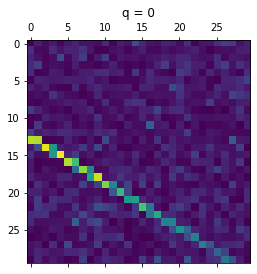

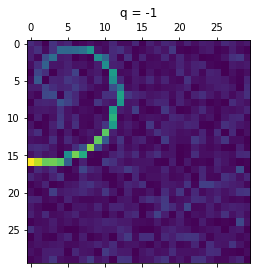

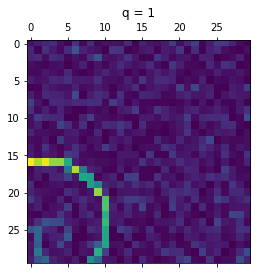

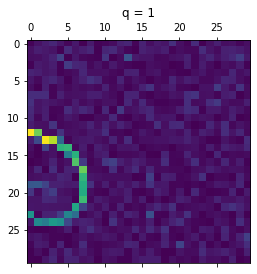

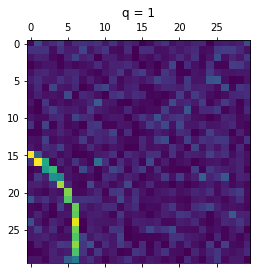

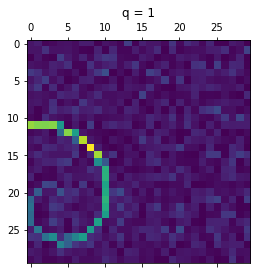

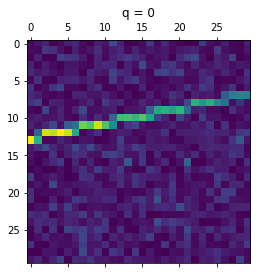

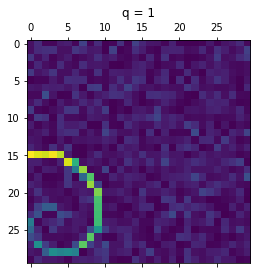

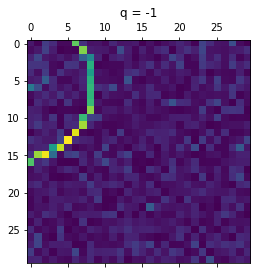

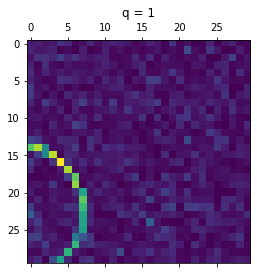

In [5]:
for i in range(10):
    plt.matshow(images[i])
    plt.title(f"q = {round(charges[i])}")
    plt.show()

**<font color='blue'>Exercise:</font>** Very large numbers and very small numbers can cause numerical instability. To avoid this, it's best to rescale the input data to a more manageable range. Computers are most sensitive to numbers that are on the order of one. Take a look at the distribution of pixel values and decide on a way to scale all of the images. What do the largest pixel values correspond to? What do the smallest pixel values correspond to? Which values are most common?

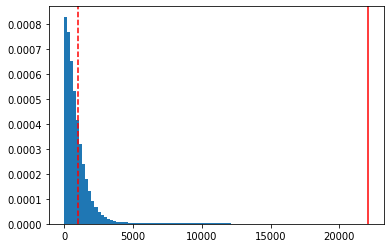

In [6]:
plt.hist(images.flatten(), density=True, bins=100)
plt.axvline(np.mean(images), color='r', linestyle='dashed')
plt.axvline(np.max(images), color='r')
plt.show()

In [7]:
scale = images.max()
print("scale = ", scale)

flat_images_scaled = flat_images / scale
images_scaled = images / scale

scale =  22106.861


**<font color='blue'>Exercise:</font>** Now let's look at our target labels: the charges. They can take values of -1, 0, or 1. We could choose to make the output of our neural network into a scalar value between -1 and 1, and minimize the mean squared error between the labels and the outputs. However, it is much better to employ **one-hot encoding** to represent each category as a binary vector. One possibility could be to assign the three different charges the following one-hot encodings:

$$\begin{align}
\textrm{charge} &= -1 &\Longrightarrow & \hspace{1cm} (1, 0, 0)\\
\textrm{charge} &= 0  &\Longrightarrow  & \hspace{1cm} (0, 1, 0)\\
\textrm{charge} &= +1  &\Longrightarrow  & \hspace{1cm} (0, 0, 1)\\
\end{align}$$

By using one-hot encodings, we can treat the outputs of our neural network as the probability of belonging to a certain class. For instance, an output of $(0.8, 0.1, 0.1)$ using the above encodings means the network is fairly certain the charge is -1, but not entirely certain the charge isn't 0 or +1. One-hot encodings also allow us to use a much more appropriate loss function for classification problems, like categorical cross-entropy, which measures how well the predicted labels match the true labels. The mathematical expression for categorical cross-entropy is given by
$$\begin{align}
C& = - \sum_{i=1}^N \mathbf{y}_i \cdot \log \mathbf{\hat{y}}_i,
\end{align}$$
where $\mathbf{y}_i$ is the $i$-th label (one-hot encoding) and $\mathbf{\hat{y}}_i$ is the $i$-th predicted label. Think about why this loss function works, keeping in mind that the elements of $\mathbf{\hat{y}}_i$ are between 0 and 1. What happens if you input a number between 0 and 1 into the natural log function? 

**<font color='blue'>Exercise:</font>** Use `Keras`'s `to_categorical` function to automatically assign one-hot encodings to all the charges. Print some of them out to see which charge was mapped to which binary vector. 

In [8]:
categories = to_categorical(charges, num_classes=3)

# print first 10 charges and assigned one-hot encodings
for i in range(10):
    print(f"{int(charges[i]):2}  ->  {categories[i]}")

 0  ->  [1. 0. 0.]
-1  ->  [0. 0. 1.]
 1  ->  [0. 1. 0.]
 1  ->  [0. 1. 0.]
 1  ->  [0. 1. 0.]
 1  ->  [0. 1. 0.]
 0  ->  [1. 0. 0.]
 1  ->  [0. 1. 0.]
-1  ->  [0. 0. 1.]
 1  ->  [0. 1. 0.]


## Feedforward neural networks

**<font color='blue'>Exercise:</font>** Let's see if we can build a feedforward neural network that can classify the tracks as accurately as humans can. In the code cell below, I have provided an example of building a shallow feedforward neural network with `Keras`'s `Sequential` model. Figure out how to replace the `...`'s appropriately, and take a few minutes to play around with some of the hyperparameters:
- [Activation functions](https://keras.io/api/layers/activations/) provide the nonlinearly needed for neural networks to learn complex relationships. The hidden activation is free for you to choose. The output activation function, on the other hand, must return values in the range of (0, 1) because we are interpreting the outputs of the network as probabilities. 
- [Loss functions](https://keras.io/api/losses/) are the functions we want to minimize. Choose losses that are compatible with one-hot encodings.
- The `monitor` keyword which controls which metric to pay attention to for early stopping.
- The number of units (or nodes) in the hidden layer.
- The number of layers.
- etc...

In [101]:
# seed here for reproducible results, you can remove this
np.random.seed(314159)

# build Keras Sequential model
model = Sequential(name='FNN')
model.add(Dense(16, input_dim=flat_images_scaled.shape[-1], activation='relu', name='hidden1'))
model.add(Dense(16, input_dim=32, activation='relu', name='hidden2'))
model.add(Dense(categories.shape[-1], activation="softmax", name='output'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
model.summary()

# create an EarlyStopping callback to stop training when converged
callback = EarlyStopping(monitor='val_accuracy', patience=100)

# fit model to data
training = model.fit(flat_images_scaled, 
                     categories, 
                     epochs=1000, 
                     validation_split=0.3, 
                     verbose=0,
                     callbacks=[callback])

Model: "FNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                14416     
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 3)                 51        
Total params: 14,739
Trainable params: 14,739
Non-trainable params: 0
_________________________________________________________________


**<font color='blue'>Exercise:</font>** How many trainable parameters does the network have? Is it large or small compared to the number of training images? If the number of trainable parameters is much larger than the number of data points, you should worry about overfitting.

**<font color='blue'>Exercise:</font>** The output of the `fit` function is a `History` object whose `History.history` attribute is a dictionary that contains a record of various metrics during training. Print out the keys of the dictionary to see what the `History` object kept track of. 

In [102]:
print(training.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


**<font color='blue'>Exercise:</font>** Plot the various metrics as a function of epochs (i.e. training iterations). Discrepancies in the converged values of `accuracy` and `val_accuracy` indicate overfitting, i.e. the network is memorizing the training data, rather than generalizing its knowledge. Is the model overfitting?

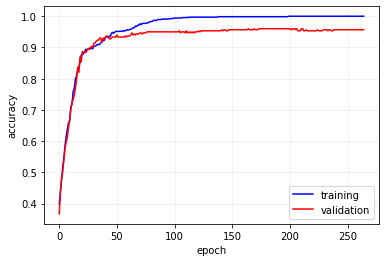

In [103]:
plt.plot(training.history['accuracy'], color='b', label='training')
plt.plot(training.history['val_accuracy'], color='r', label='validation')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

The validation set is a portion of the input data that is set aside to assess the training. You want to have training accuracy and validation accuracy curves that follow each other closely. My curves have a small gap between them. This typically means we are overtraining, i.e. the knowledge we have gained is not very generalizable. This is to be expected because the neural network I chose is huge compared to the number of data points!

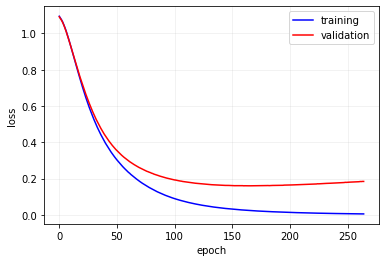

In [104]:
plt.plot(training.history['loss'], color='b', label='training')
plt.plot(training.history['val_loss'], color='r', label='validation')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Same thing with the loss function; we want the curves to follow each other more closely than this. 

**<font color='blue'>Exercise:</font>** Retrain the neural network model using the unscaled data and plot the same metrics as above. You should expect more difficulties here. 

In [105]:
# fit model to data
training = model.fit(flat_images, 
                     categories, 
                     epochs=1000, 
                     validation_split=0.3, 
                     batch_size=10, 
                     verbose=0,
                     callbacks=[callback])

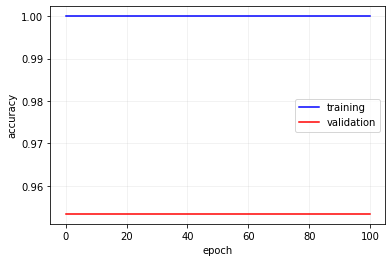

In [106]:
plt.plot(training.history['accuracy'], color='b', label='training')
plt.plot(training.history['val_accuracy'], color='r', label='validation')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

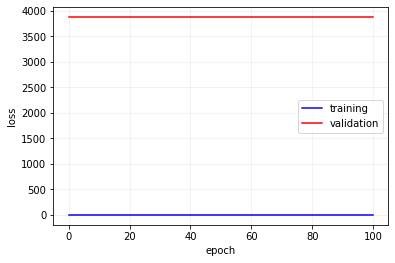

In [107]:
plt.plot(training.history['loss'], color='b', label='training')
plt.plot(training.history['val_loss'], color='r', label='validation')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

As you can see, training completely failed without rescaling the data.

## Convolutional neural networks

**<font color='blue'>Exercise:</font>** Instead of flattening the data and passing it through a feedforward neural network, let us take advantage of 2D convolutional layers to process the 2D image data. Again, I have provided the skeleton of the code below. You will need to reshape the scaled image data to be compatible with `Keras`'s `Conv2D` object. Play around with the number of filters, kernel size, and pool size. 

In [108]:
# reshape scaled image data
images_scaled = images_scaled.reshape((1000, 30, 30, 1))

# build Keras Sequential model
model = Sequential(name='CNN')
model.add(Conv2D(2, (3, 3), input_shape=(30, 30, 1), activation='relu', name='convolution1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pooling1'))
model.add(Flatten(name='flatten'))
model.add(Dense(categories.shape[-1], activation="softmax", name='output'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()

# fit model to data
training = model.fit(images_scaled, 
                     categories, 
                     epochs=500, 
                     validation_split=0.3, 
                     batch_size=10, 
                     verbose=0,
                     callbacks=[callback])

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 2)         20        
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 1179      
Total params: 1,199
Trainable params: 1,199
Non-trainable params: 0
_________________________________________________________________


**<font color='blue'>Exercise:</font>** How does the number of parameters compare to the feedforward neural network example?

**<font color='blue'>Exercise:</font>** Plot the various metrics and access for overfitting. How does it compare with the training curves of the FNNs?

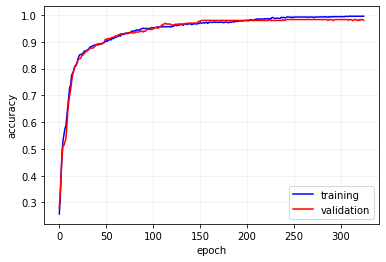

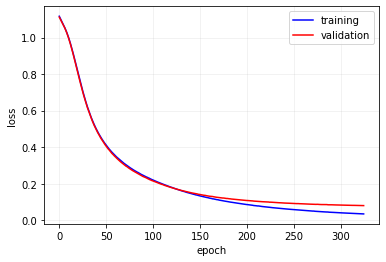

In [109]:
plt.plot(training.history['accuracy'], color='b', label='training')
plt.plot(training.history['val_accuracy'], color='r', label='validation')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

plt.plot(training.history['loss'], color='b', label='training')
plt.plot(training.history['val_loss'], color='r', label='validation')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

**<font color='blue'>Exercise:</font>** As a final challenge, experiment with how small of a network you can make that has at least 95% validation accuracy. 